In [36]:
import pickle
import pandas as pd
from pprint import pprint
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

### Read author file

In [2]:
with open("authors_gscholar_scrapped.pickle", "rb") as f:
    all_authors_gs = pickle.load(f)

print(len(all_authors_gs))

1404


In [3]:
list(all_authors_gs.keys())[0:5]

['', 'Max Jaderberg', 'Moshe Looks', 'Todd Mytkowicz', 'Stefano Soatto']

In [5]:
len(all_authors_gs["Max Jaderberg"])

1

In [11]:
print(all_authors_gs["Max Jaderberg"][0][0])

{'_filled': True,
 'affiliation': 'DeepMind',
 'citedby': 7878,
 'citedby5y': 7835,
 'cites_per_year': {2014: 24,
                    2015: 134,
                    2016: 565,
                    2017: 1085,
                    2018: 1944,
                    2019: 2958,
                    2020: 1092},
 'coauthors': [<scholarly.scholarly.Author object at 0x7f47015ddbe0>,
 'email': '@robots.ox.ac.uk',
 'hindex': 21,
 'hindex5y': 21,
 'i10index': 22,
 'i10index5y': 22,
 'id': 'JeZoMicAAAAJ',
 'interests': ['Machine Learning'],
 'name': 'Max Jaderberg',
 'publications': [<scholarly.scholarly.Publication object at 0x7f47015e50b8>,
 'url_picture': 'https://scholar.google.com/citations?view_op=medium_photo&user=JeZoMicAAAAJ'}


In [31]:
for pp in all_authors_gs["Max Jaderberg"][0][0].publications:
    print(pp, pp.bib)
    break

{'_filled': False,
 'bib': {'title': 'Spatial Transformer Networks', 'year': 2015},
 'citedby': 2849,
 'id_citations': 'JeZoMicAAAAJ:L8Ckcad2t8MC',
 'source': 'citations'} {'title': 'Spatial Transformer Networks', 'year': 2015}


### Add conflicts data

In [13]:
data_path = "../../ICLR data/masterdata_unbalanced/"

years = [2017]

for y in years:
    papers_data = pd.read_pickle(data_path + "papers_{}.pkl".format(y))

In [14]:
conflicts_dict = {}
emails_dict = {}

for p in papers_data:
    conflicts_dict[p] = papers_data[p]["content"]["conflicts"]
    emails_dict[p] = papers_data[p]["content"]["authorids"]

### Read features

In [226]:
data_raw = pd.read_pickle('../features/data_features_csv-2017.pkl')
data = data_raw[["id", "title", "label", "authors"]]
org_papers = data.to_dict('index')

### Disambiguate authors based on email

In [173]:
paper_authors_info = defaultdict(dict)
per_paper = defaultdict(list)

still_not_found = 0
total_auth_count = 0
found_count = 0
not_in_gs = 0
cc = 0

still_not_found_list = []

for p in org_papers:
    for auth in org_papers[p]["authors"]:
#         found = False
        total_auth_count += 1
        disambiguated_author = None
        if auth in all_authors_gs:
            if len(all_authors_gs[auth]) == 1:
                disambiguated_author = all_authors_gs[auth][0][0]
                found_count += 1
            else:
                #print(p, auth, conflicts_dict[p], emails_dict[p])
                #print("--------------------------------------------------------------------------------------")
                found_paper = False
                for mauth in all_authors_gs[auth]:
                    #print(mauth[0].name, mauth[0].email, mauth[0].interests)
                    for pub in mauth[0].publications:
                        org_title = ''.join(filter(str.isalpha, org_papers[p]["title"].lower()))
                        gs_pub_title = ''.join(filter(str.isalpha, pub.bib["title"].lower()))
                        if org_title == gs_pub_title:
                            found_paper = True
                            disambiguated_author = mauth[0]
                            found_count += 1
                            break
                    if found_paper:
                        break
                if not found_paper:
                    # Paper not found, check via conflicts/email information
                    matching_affils = []
                    
                    for conflict_affil in conflicts_dict[p]:
                        for mauth in all_authors_gs[auth]:
                            if mauth[0].email.find(conflict_affil) > -1:
                                matching_affils.append(mauth)
                    
                    # still not found
                    if len(matching_affils) == 0:
                        still_not_found += 1
                        still_not_found_list.append(auth)
                    elif len(matching_affils) == 1:
                        disambiguated_author = matching_affils[0][0]
                        found_count += 1
                    else:
#                         still_not_found +=1
#                         still_not_found_list.append(auth)
                        potential_emailids = []
                        auth_split = auth.split(" ")
                        for splitname in auth_split:
                            for authemailid in emails_dict[p]:
                                if authemailid.find(splitname) > -1:
                                    potential_emailids.append(authemailid)
                                    
                        potential_emailids = list(set(potential_emailids))
                        if len(potential_emailids) == 1:
                            domain = potential_emailids[0].split("@")[-1]
                            identified_auth = []
                            for m in matching_affils:
                                if m[0].email.find(domain) > -1:
                                    identified_auth.append(m[0])
                            
                            if len(identified_auth) == 1:
                                disambiguated_author = m[0]
                                found_count +=1 
                            else:
                                still_not_found += 1
                                still_not_found_list.append(auth)
#                                 print(p, auth, conflicts_dict[p], emails_dict[p], [(m[0].name, m[0].email) for m in matching_affils])
                        else:
                            still_not_found += 1
                            still_not_found_list.append(auth)
#                             print("----")
#                             print(p, auth, conflicts_dict[p], emails_dict[p], potential_emailids)
            if not disambiguated_author is None:
                cc +=1
                paper_authors_info[auth] = disambiguated_author
                per_paper[p].append(auth)
        else:
            not_in_gs +=1

In [175]:
print("Found authors: ", found_count)
print("Added to dict: ", cc)
print("Multiple entries in GS but no publication with the same title found or empty GS: ", still_not_found)
print("NOt in GS data: ", not_in_gs)
print("Total authors to be disambiguated: ", total_auth_count)

Found authors:  1581
Added to dict:  1581
Multiple entries in GS but no publication with the same title found or empty GS:  205
NOt in GS data:  23
Total authors to be disambiguated:  1809


In [178]:
len(list(set(still_not_found_list))), list(set(still_not_found_list))[10:20], not_in_gs

(197,
 ['Takeshi Onishi',
  'Masanori Misono',
  'Ping Tak Peter Tang',
  'Jing Dong',
  'Jose Sotelo',
  'Kevin Jamieson',
  'Xiao Bing Huang',
  'David Lopez-Paz',
  'Greg Yang',
  'Joseph P. Bigus'],
 23)

In [179]:
len(paper_authors_info), 1425-len(paper_authors_info)

(1210, 215)

In [181]:
#Total papers for which atleast one author is found
len(per_paper), len(org_papers)

(479, 490)

### Saving the publication count, citation count and hindex

In [234]:
for k, v in org_papers.items():
    org_papers[k]["pub_count_gs"] = []
    org_papers[k]["cit_count_gs"] = []
    org_papers[k]["hindex"] = []
    
    for a in v["authors"]:
        if a in paper_authors_info:
            temp_auth_dict = paper_authors_info[a].__dict__
            if "citedby" in temp_auth_dict and temp_auth_dict["citedby"] > 0:
                total_citations = temp_auth_dict["citedby"]
                if "cites_per_year" in temp_auth_dict:
                    for y in temp_auth_dict["cites_per_year"]:
                        if y > 2016:
                            total_citations -= temp_auth_dict["cites_per_year"][y]
                org_papers[k]["cit_count_gs"].append(total_citations)
            if "hindex" in temp_auth_dict:
                if "hindex5y" in temp_auth_dict:
                    org_papers[k]["hindex"].append((temp_auth_dict["hindex5y"] + temp_auth_dict["hindex"])/2)
                else:
                    org_papers[k]["hindex"].append(temp_auth_dict["hindex"])
            if "publications" in temp_auth_dict:
                total_publications = 0
                for pub in temp_auth_dict["publications"]:
                    if "year" in pub.__dict__["bib"]:
                        if pub.__dict__["bib"]["year"] < 2017:
                            total_publications += 1
                    else:
                        total_publications += 1
                org_papers[k]["pub_count_gs"].append(total_publications)

In [235]:
list(org_papers.keys())[0:10]

['ByBwSPcex',
 'rJeKjwvclx',
 'B1jnyXXJx',
 'ryF7rTqgl',
 'HyNxRZ9xg',
 'r1fYuytex',
 'HJeqWztlg',
 'H1_EDpogx',
 'BysZhEqee',
 'Hk8TGSKlg']

In [236]:
org_papers["ByBwSPcex"]

{'authors': ['Hang Chu', 'Raquel Urtasun', 'Sanja Fidler'],
 'cit_count_gs': [47, 9085, 2451],
 'hindex': [9.5, 72.0, 48.0],
 'id': 'ByBwSPcex',
 'label': 'Invite',
 'pub_count_gs': [10, 202, 119],
 'title': 'Song From PI: A Musically Plausible Network for Pop Music Generation'}

# Sump the info

In [238]:
with open("GS_augmented_2017_iclr.pickle", "wb") as f:
    pickle.dump(org_papers, f)

In [239]:
ls

author_info_scholar_compressed.zip  DisambiguateGSAuthors.ipynb
author_info_scholar_local_comp.zip  Filter2016data.ipynb
author_info_scholar_local.pickle    GS_augmented_2017_iclr.pickle
author_info_scholar.pickle          mag_augmented_2017_iclr.pickle
author_server_part.pickle           read_mag_data.ipynb
author_server_part.zip              read_ms_kdd.ipynb
authors_gscholar_scrapped.pickle    split_authors_for_local.txt


In [243]:
cp GS_augmented_2017_iclr.pickle ../features

In [244]:
ls ../features

all_data_features_17_20.pkl
all_data_features_csv_17_20_new.pkl
all_data_features_csv_2017_new.pkl
all_data_features_csv_2017_with_aspect_scores.pkl
data_csv-2017-20.pkl
data_features_csv-2017.pkl
features_csv_17_20.pkl
GS_augmented_2017_iclr.pickle
mag_features_2017_iclr.pickle
rev_aspects_2017_peerread.pkl


In [231]:
paper_authors_info["Raquel Urtasun"].__dict__
#["publications"][0].__dict__["bib"]

{'_filled': True,
 'affiliation': 'Associate Professor, University of Toronto',
 'citedby': 27708,
 'citedby5y': 23060,
 'cites_per_year': {2006: 107,
  2007: 156,
  2008: 203,
  2009: 333,
  2010: 456,
  2011: 471,
  2012: 622,
  2013: 883,
  2014: 1202,
  2015: 1734,
  2016: 2640,
  2017: 3613,
  2018: 4989,
  2019: 7455,
  2020: 2566},
 'coauthors': [<scholarly.scholarly.Author at 0x7f470afc04a8>,
 'email': '@cs.toronto.edu',
 'hindex': 77,
 'hindex5y': 67,
 'i10index': 162,
 'i10index5y': 152,
 'id': 'jyxO2akAAAAJ',
 'interests': ['Machine Learning',
  'Computer Vision',
  'Artificial Intelligence'],
 'name': 'Raquel Urtasun',
 'publications': [<scholarly.scholarly.Publication at 0x7f470afc09b0>,
 'url_picture': 'https://scholar.google.com/citations?view_op=medium_photo&user=jyxO2akAAAAJ'}

In [216]:
for k, v in paper_authors_info.items():
#     print(paper_authors_info[k].citedby)
#     break
    temp = paper_authors_info[k].__dict__
    if not "citedby" in temp.keys():# and temp["citedby"] == 0:
        pprint(temp)
#         break

{'_filled': True,
 'affiliation': 'Google Inc',
 'cites_per_year': {},
 'coauthors': [],
 'email': '@google.com',
 'hindex': 0,
 'hindex5y': 0,
 'i10index': 0,
 'i10index5y': 0,
 'id': 's8PV87cAAAAJ',
 'interests': ['computer science'],
 'name': 'Andrew Nystrom',
 'publications': [<scholarly.scholarly.Publication object at 0x7f46fc6d4e48>],
 'url_picture': 'https://scholar.google.com/citations?view_op=medium_photo&user=s8PV87cAAAAJ'}
{'_filled': True,
 'affiliation': 'Marie Curie Early Stage Researcher at the University of '
                'Nottingham',
 'cites_per_year': {},
 'coauthors': [],
 'email': '',
 'hindex': 0,
 'hindex5y': 0,
 'i10index': 0,
 'i10index5y': 0,
 'id': 'xutRx6IAAAAJ',
 'interests': ['Optimisation', 'acoustics', 'vibration'],
 'name': 'Vivek Thaminni Ramamoorthy',
 'publications': [<scholarly.scholarly.Publication object at 0x7f4704fc48d0>],
 'url_picture': 'https://scholar.google.com/citations?view_op=medium_photo&user=xutRx6IAAAAJ'}
{'_filled': True,
 'affili

# Scratch

#### Disambiguation via conflicts emailids

In [59]:
for a in still_not_found_list:
    if a in all_authors_gs:
        print(a, all_authors_gs[a])
        break

Ying Wen [(<scholarly.scholarly.Author object at 0x7f46fb6ddb38>, <scholarly.scholarly.Author object at 0x7f46fb6ddb38>), (<scholarly.scholarly.Author object at 0x7f46fb668c88>, <scholarly.scholarly.Author object at 0x7f46fb668c88>), (<scholarly.scholarly.Author object at 0x7f46fb670c18>, <scholarly.scholarly.Author object at 0x7f46fb670c18>), (<scholarly.scholarly.Author object at 0x7f46fb67bac8>, <scholarly.scholarly.Author object at 0x7f46fb67bac8>), (<scholarly.scholarly.Author object at 0x7f46fb67beb8>, <scholarly.scholarly.Author object at 0x7f46fb67beb8>), (<scholarly.scholarly.Author object at 0x7f46fb684b00>, <scholarly.scholarly.Author object at 0x7f46fb684b00>), (<scholarly.scholarly.Author object at 0x7f46fb68d6a0>, <scholarly.scholarly.Author object at 0x7f46fb68d6a0>), (<scholarly.scholarly.Author object at 0x7f46fb695048>, <scholarly.scholarly.Author object at 0x7f46fb695048>), (<scholarly.scholarly.Author object at 0x7f46fb695588>, <scholarly.scholarly.Author object at 

In [63]:
for p in org_papers:
    for auth in org_papers[p]["authors"]:
        if auth == "Ying Wen":
            print(org_papers[p])
            print(emails_dict[p])
            print(conflicts_dict[p])

{'id': 'HyNxRZ9xg', 'title': 'Cat2Vec: Learning Distributed Representation of Multi-field Categorical Data', 'authors': ['Ying Wen', 'Jun Wang', 'Tianyao Chen', 'Weinan Zhang'], 'label': 'Reject'}
['ying.wen@cs.ucl.ac.uk', 'jun.wang@cs.ucl.ac.uk', 'tychen@apex.sjtu.edu.cn', 'wnzhang@apex.sjtu.edu.cn']
['ucl.ac.uk', 'sjtu.eud.cn']


In [73]:
for ma in all_authors_gs["Ying Wen"]:
    print("{:25} {:25} {:15}".format(ma[0].name, ma[0].email, ma[0].affiliation))

Yingwen Cheng             @niu.edu                  Chemistry and Biochemistry, Northern Illinois University
Rachel Ying-Wen Chang     @utoronto.ca              Assistant Professor, Dalhousie University
Bei-Wen Ying              @u.tsukuba.ac.jp          University of Tsukuba
Yin-Wen Chang             @google.com               Google Inc.    
Yin-Wen Lee               @ntut.edu.tw              Taipei Tech.; NTU; OFS Labs.; Stanford University;
Yingwen Zhang             @nrc-cnrc.gc.ca           National Research Council
Wen Yin                   @intel.com                Intel Corporation
Ying Wen                  @cs.ucl.ac.uk             PhD Student, University College London
Yingwen Hu                @nih.gov                  Nanotechnology Characterization Laboratory / Leidos Biomedical Research, Inc.
Wen Yin                   @tuhep.phys.tohoku.ac.jp  Tokyo University
Yi-Ying Wen               @ccu.edu.tw               National Chung Cheng University
Wen Ying-hao              @cgm

#### As can be seen in above, conflicts email are usually substr of the proper email affil provided by GS
#### Conflict can be with the whole CS Dept, affil can be univ id etc

#### Some exceptions to the above case (paperId, Name, afil, email, gs_authors_tuples):
#### Sy7m72Ogg Gang Wang ['nankai.edu.cn', 'microsoft.com'] ['changxu@nbjl.nankai.edu.cn', 'taoqin@microsoft.com', 'wgzwp@nbjl.nankai.edu.cn', 'tie-yan.liu@microsoft.com'] [('Gang Wang', '@nbjl.nankai.edu.cn'), ('Zhi-Gang Wang', '@nankai.edu.cn')]

In [93]:
for a in all_authors_gs["Gang Wang"]:
    if a[0].email in ['@nbjl.nankai.edu.cn', '@nankai.edu.cn']:
        try:
            print(a[0].name, a[0].email, a[0].citedby, a[0].interests)
        except Exception as ex:
            continue

Gang Wang @nbjl.nankai.edu.cn 2711 []
Zhi-Gang Wang @nankai.edu.cn 425 ['Single-particle tracking', 'Biotechnology', 'Bioimaging.']


In [130]:
org_papers["Sy7m72Ogg"]

{'authors': ['Chang Xu', 'Tao Qin', 'Gang Wang', 'Tie-Yan Liu'],
 'id': 'Sy7m72Ogg',
 'label': 'Reject',
 'title': 'An Actor-critic Algorithm for Learning Rate Learning'}

#### Turns out this paper is scholar is not linked to the author we found above. In fact, no author/gs_user_profile is linked in the paper on scholar

#### SyJNmVqgg Yang Fan ['microsoft.com', 'ustc.edu.cn'] ['v-yanfa@microsoft.com', 'fetia@microsoft.com', 'taoqin@microsoft.com', 'tie-yan.liu@microsoft.com'] [('Fan Yang', '@microsoft.com'), ('Yang Fan', '@mail.ustc.edu.cn')]

In [92]:
for a in all_authors_gs["Yang Fan"]:
    if a[0].email in [ '@microsoft.com',  '@mail.ustc.edu.cn']:
        try:
            print(a[0].name, a[0].email, a[0].citedby, a[0].interests)
        except Exception as ex:
            continue

Fan Yang @microsoft.com 1833 ['Systems and networking']
Yang Fan @mail.ustc.edu.cn 104 []


### Turns out that the actual author above has a google scholar page with name "Yi-Zheng Fan" :/ 

In [95]:
a[0].interests

['Data Mining']

In [109]:
sub = "bio"
[s for s in filter (lambda x: sub in x.lower(), ["data mining", "Biochemical", "Chem"])]

['Biochemical']

In [182]:
# Most of the 215 missing authors are not present in google schoalr itself.

In [ ]:
Carl Denton, Noam Shazeer

In [134]:
all_authors_gs["Takeshi Onishi"]

[]

In [135]:
import scholarly

In [149]:
test_auth = defaultdict(list)

c = scholarly.search_author("Takeshi Onishi")
for i in c:
    test_auth["Takeshi Onishi"].append((i, i.fill()))

In [150]:
c = scholarly.search_author("Carl Denton")
for i in c:
    test_auth["Carl Denton"].append((i, i.fill()))

In [151]:
c = scholarly.search_author("Yuanjun Gao")
for i in c:
    test_auth["Yuanjun Gao"].append((i, i.fill()))

In [152]:
test_auth

defaultdict(list,
            {'Yuanjun Gao': [(<scholarly.scholarly.Author at 0x7f46f6b0a9e8>,
               <scholarly.scholarly.Author at 0x7f46f6b0a9e8>)]})

In [156]:
print(test_auth["Yuanjun Gao"][0][0])

{'_filled': True,
 'affiliation': 'Columbia University',
 'citedby': 588,
 'citedby5y': 586,
 'cites_per_year': {2014: 2,
                    2015: 5,
                    2016: 43,
                    2017: 101,
                    2018: 166,
                    2019: 196,
                    2020: 73},
 'coauthors': [<scholarly.scholarly.Author object at 0x7f46f6adb358>,
 'email': '@columbia.edu',
 'hindex': 5,
 'hindex5y': 5,
 'i10index': 5,
 'i10index5y': 5,
 'id': 'jfdR-6kAAAAJ',
 'interests': ['Machine Learning', 'Neuroscience', 'Statistics'],
 'name': 'Yuanjun Gao',
 'publications': [<scholarly.scholarly.Publication object at 0x7f46f6adb6d8>,
 'url_picture': 'https://scholar.google.com/citations?view_op=medium_photo&user=jfdR-6kAAAAJ'}


In [ ]:
try_again = list(set(still_not_found_list))

# test_auth_again = defaultdict(list)
idx = len(test_auth_again)

for reauth in try_again[32:]:
    print(idx)
    idx+=1
    if not reauth in test_auth_again:
        try:
            c = scholarly.search_author(reauth)
            if c:
                for i in c:
                    test_auth_again[reauth].append((i, i.fill()))
            else:
                test_auth_again[reauth] = []
        except Exception as ex:
            continue

In [164]:
len(test_auth_again)

20

In [168]:
itera = 0
for a in test_auth_again:
    if not a in all_authors_gs:
        print(itera+1)
        all_authors_gs[a] = test_auth_again[a]

In [169]:
len(all_authors_gs)

1404

In [172]:
len(all_authors_gs["Xiao Liu"])

75

In [3]:
with open("GS_augmented_2017_iclr.pickle", "rb") as f:
    t = pickle.load(f)

In [5]:
t["B1-Hhnslg"]

{'authors': ['Jake Snell', 'Kevin Swersky', 'Richard Zemel'],
 'cit_count_gs': [16, 901, 8869],
 'hindex': [5.0, 24.0, 52.0],
 'id': 'B1-Hhnslg',
 'label': 'Reject',
 'pub_count_gs': [0, 37, 202],
 'title': 'Prototypical Networks for Few-shot Learning'}

In [8]:
count = defaultdict(int)
for k, v in t.items():
    sub = len(v["authors"])-len(v["cit_count_gs"])
    count[v["label"]] += sub

In [9]:
count

defaultdict(int, {'Accept': 74, 'Invite': 15, 'Reject': 139})

In [11]:
139+74

213

In [63]:
count_hist = defaultdict(list)

for k, v in t.items():
    sub = len(v["authors"])-len(v["cit_count_gs"])
    count_hist[v["label"]].append(round(sub/len(v["authors"]), 1))

In [83]:
acc_counter = Counter(count_hist["Accept"])
rej_counter = Counter(count_hist["Reject"])
acc_counter, rej_counter

(Counter({0.0: 147, 0.1: 3, 0.2: 25, 0.3: 7, 0.4: 3, 0.5: 9, 0.6: 1, 0.7: 3}),
 Counter({0.0: 153,
          0.1: 2,
          0.2: 32,
          0.3: 14,
          0.4: 6,
          0.5: 17,
          0.6: 4,
          0.7: 2,
          0.8: 4,
          1.0: 11}))

In [84]:
# All accepted (198) and rejected (245) counted
len(count_hist["Reject"]), len(count_hist["Accept"])

(245, 198)

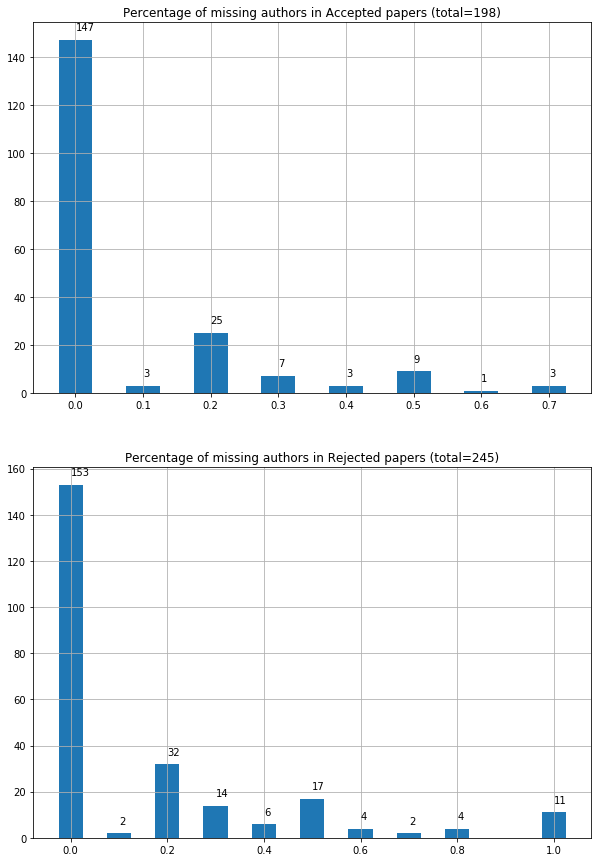

In [93]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 15))

# Accepted papers
x1 = []
y1 = []
for k, v in acc_counter.items():
    x1.append(k)
    y1.append(v)
ax1.bar(x1, y1, 0.05)
for index,d in enumerate(y1):
    ax1.text(x=x1[index], y=d+4, s="{0:g}".format(d),fontdict=dict(fontsize=10))
ax1.set_title("Percentage of missing authors in Accepted papers (total=198)")
ax1.grid()

# # Rejected Papers
x1 = []
y1 = []
for k, v in rej_counter.items():
    x1.append(k)
    y1.append(v)
ax2.bar(x1, y1, 0.05)
for index,d in enumerate(y1):
    ax2.text(x=x1[index], y=d+4, s="{0:g}".format(d),fontdict=dict(fontsize=10))
ax2.set_title("Percentage of missing authors in Rejected papers (total=245)")
ax2.grid()

plt.savefig("../images/Paper_authors_missing_wrt_acceptance.png")
plt.show()